In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import h5py
import pandas as pd 
import random 
import torch
import sys
import os
from torch.utils.data import DataLoader,random_split,TensorDataset 
from torch import nn
from torch.utils.tensorboard import SummaryWriter

In [2]:
sys.path.append('/mnt/home/jzang/frg/freq_frg/code')
from models import Autoencoder
from cost import train_epoch, test_epoch

In [3]:
os.environ['TENSORBOARD_BINARY'] = '/mnt/home/jzang/frg/torch_env/bin/tensorboard'

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA available:', torch.cuda.get_device_name(0))
    print('CUDNN version:', torch.backends.cudnn.version())
    GPU_MEM = torch.cuda.get_device_properties(0).total_memory/(1024**2)
    print(f'Available GPU memory: {GPU_MEM:.2f} MB')
else:
    device = torch.device('cpu')
    print('CUDA not available')
    

CUDA available: NVIDIA A100-SXM4-80GB
CUDNN version: 8200
Available GPU memory: 81221.81 MB


In [6]:
filename = "/mnt/home/jzang/ceph/freq_frg/SIAM.KF.U3.0.T1.0.e0.0.h5"
with h5py.File(filename, 'r') as file:
    mesh_bosonic=np.array(file['vertex_total']['mesh_bosonic'])
    mesh_fermionic_1 = np.array(file['vertex_total']['mesh_fermionic_1'])
    mesh_fermionic_2 = np.array(file['vertex_total']['mesh_fermionic_2'])

In [7]:
part=14

In [8]:
filename = f"/mnt/home/jzang/ceph/freq_frg/store_data/vertex_total_uddu_part{part}.h5"
with h5py.File(filename, 'a') as file:
    vertex_uddu=np.array(file['vertex_uddu'])
    vertex_uddu_mean=np.array(file['vertex_uddu_mean'])
    table=np.array(file['parameters'])
    indice=np.array(file['indice'])

In [9]:
vertex_uddu.shape

(140, 201, 101, 101)

In [10]:
### Set the random seed for reproducible results
torch.manual_seed(0)
np.random.seed(0)

In [11]:
# Separate real and imaginary parts
vertex_uddu_real = vertex_uddu.real.astype(np.float32)
vertex_uddu_imag = vertex_uddu.imag.astype(np.float32)
# Stack along a new axis to create a new channel dimension
vertex_uddu_stacked = np.stack([vertex_uddu_real, vertex_uddu_imag], axis=1)  # shape: (140, 2, 201, 101, 101)
del vertex_uddu, vertex_uddu_real, vertex_uddu_imag

In [12]:
# Generate indices and shuffle them
indices = np.arange(vertex_uddu_stacked.shape[0])
np.random.shuffle(indices)
# Split indices for training and testing
train_indices = indices[:110]
test_indices =indices[110:]# np.arange(vertex_uddu_stacked.shape[0])# indices[110:]
# Split vertex_uddu data
vertices_train = torch.tensor(vertex_uddu_stacked[train_indices])
vertices_test = torch.tensor(vertex_uddu_stacked[test_indices])
# Split couplings data
couplings_train = torch.tensor(table[train_indices])
couplings_test = torch.tensor(table[test_indices])

In [13]:
vertex_uddu_stacked= torch.tensor(vertex_uddu_stacked)
couplings_total= torch.tensor(table)

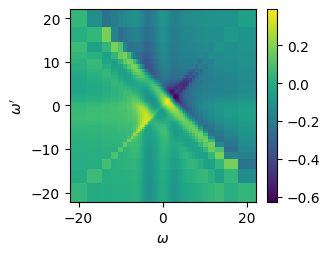

In [14]:
plt.figure(figsize=(3,2.5))
X, Y = np.meshgrid(mesh_fermionic_1, mesh_fermionic_2)
plt.pcolormesh(X, Y,vertices_train[1,0,50,:,:])
plt.xlabel(f"$\omega$")
plt.ylabel(f"$\omega'$")
plt.colorbar()

In [15]:
def tensor_size_in_gigabytes(tensor):
    return (tensor.element_size() * tensor.nelement()) / (1024 ** 3)
print(f"Tensor size in gigabytes: {tensor_size_in_gigabytes(vertices_test):.9f} GB")




Tensor size in gigabytes: 0.458300337 GB


In [16]:
batch_size = 32
if batch_size <= vertices_train.shape[0]:
    dset_train = TensorDataset(vertices_train , couplings_train)
    loader_train = DataLoader(dset_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
else:
    raise RuntimeError(
        'Batch size must be smaller than the number of training '
        f'trajectories {vertices_train.shape[0]}. Got {batch_size}'
    )

in_dim = couplings_train.shape[-1]
dset_test = TensorDataset(vertices_test , couplings_test)
loader_test = DataLoader(dset_test, batch_size=32)

dset_total = TensorDataset(vertex_uddu_stacked , couplings_total)
loader_total = DataLoader(dset_total, batch_size=batch_size)

In [17]:
#check size
v, c  = next(iter(loader_train))
print(f"vertices batch shape: {v.size()}")
print(f"couplings batch shape: {c.size()}")

vertices batch shape: torch.Size([32, 2, 201, 101, 101])
couplings batch shape: torch.Size([32, 3])


In [18]:
d =2
hidden=32
ae =Autoencoder(latent_dims=d,hidden_dim=hidden)
lr = 1e-3
weight_decay = 0#1e-5
optim = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
ae.to(device)

Selected device: cuda


Autoencoder(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Conv3d(2, 32, kernel_size=(2, 2, 2), stride=(1, 1, 1))
      (1): GELU()
      (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1))
      (4): GELU()
      (5): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv3d(32, 32, kernel_size=(9, 4, 4), stride=(1, 1, 1))
      (7): GELU()
      (8): MaxPool3d(kernel_size=(2, 2, 2), stride=(4, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (10): GELU()
      (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Flatten(start_dim=1, end_dim=-1)
      (13): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (14): Linear(in_features=2048, out_features=2, bias=True)
    )
  )
  (d

In [19]:
sum(param.numel() for param in ae.parameters())

625892

In [20]:
def plot_ae_outputs(dset,encoder,decoder,sample=5,k3=20,text="train"):
    
    x=dset[:][0].to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        x_hat  = decoder(encoder(x))
    x_array=x.cpu().detach().numpy()
    
    plt.figure(figsize=(3,2.5))
    original=np.sqrt(x_array[sample,0,k3,:,:]**2+x_array[sample,1,k3,:,:]**2)
    max_v=np.max(original)
    min_v=np.min(original)
    plt.pcolormesh(original,vmax=max_v,vmin=min_v)
    plt.title(f"original, {text}")
    plt.colorbar()
    plt.show()
    
    x_pred_array=x_hat.cpu().detach().numpy()
    plt.figure(figsize=(3,2.5))
    recon=np.sqrt(x_pred_array[sample,0,k3,:,:]**2+x_pred_array[sample,1,k3,:,:]**2)
    plt.pcolormesh(recon,vmax=max_v,vmin=min_v)    # plt.ylabel(f"$\omega'$")
    plt.title(f"reconstruct, {text}")
    plt.colorbar()
    plt.show()
    return x_array,  x_pred_array



In [21]:
import datetime
run_name = f"part={part}_hidden_dim={hidden}_lr={lr}_batch_size={batch_size}_Wdecay={weight_decay}_latentd={d}"
run_name


'part=14_hidden_dim=32_lr=0.001_batch_size=32_Wdecay=0_latentd=2'

In [71]:
# Initialize SummaryWriter
writer = SummaryWriter(f"runs/new_model/{run_name}")
num_epochs =600
diz_loss = {'train_loss':[], 'test_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(ae, device, loader_train, optim)
    test_loss, errors = test_epoch(ae, device, loader_test)
    # Log losses to TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Test', test_loss, epoch)
    if epoch % 50 == 0:
        # plot_ae_outputs(dset_train, ae.encoder, ae.decoder, text="train")
        # plot_ae_outputs(dset_test, ae.encoder, ae.decoder, text="test")
        print('\n EPOCH {}/{} \t train loss {:.3f} '.format(epoch + 1, num_epochs, train_loss))
        print(np.around(errors[:36], 3))

    diz_loss['train_loss'].append(train_loss)
    diz_loss['test_loss'].append(test_loss)

# Close the writer when you are done
writer.close()



 EPOCH 1/600 	 train loss 19.704 
[15.437  1.615  2.032 15.268 10.507  1.733 16.18  13.952 18.449  2.376
 10.69  12.448 10.095 10.933 16.211 15.49  18.034  4.211 10.786 12.985
 33.336 10.649 21.706 10.74  12.581 11.997  1.693  1.67  13.829 18.69 ]

 EPOCH 51/600 	 train loss 0.507 
[0.227 0.919 0.969 0.214 0.202 0.811 0.229 0.209 1.03  0.827 0.207 0.208
 1.151 0.205 0.238 0.987 0.249 0.904 0.204 1.136 0.958 0.204 0.948 0.203
 0.833 0.217 1.08  1.086 0.224 0.27 ]

 EPOCH 101/600 	 train loss 0.372 
[0.138 0.677 0.875 0.131 0.095 0.63  0.149 0.12  0.953 0.504 0.098 0.13
 0.994 0.098 0.156 0.852 0.176 0.781 0.094 0.95  0.914 0.096 0.861 0.096
 0.587 0.14  1.001 1.016 0.132 0.201]

 EPOCH 151/600 	 train loss 0.245 
[0.104 0.375 0.602 0.095 0.063 0.452 0.115 0.085 0.544 0.255 0.066 0.091
 0.675 0.066 0.124 0.532 0.143 0.536 0.064 0.483 0.41  0.064 0.423 0.064
 0.384 0.1   0.821 0.879 0.1   0.166]

 EPOCH 201/600 	 train loss 0.165 
[0.073 0.248 0.29  0.072 0.046 0.394 0.084 0.062 0.521 0.

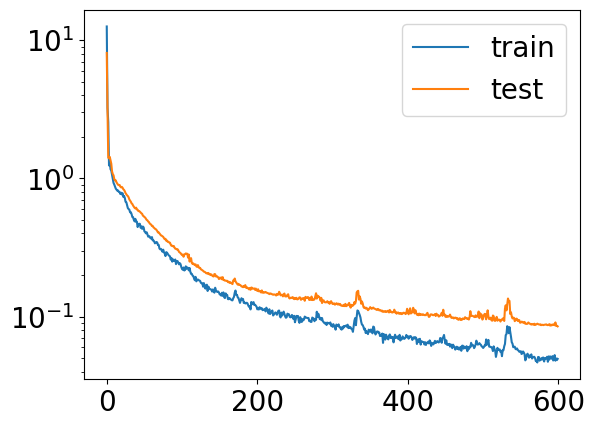

In [63]:
plt.plot(diz_loss['train_loss'],label="train")
plt.plot(diz_loss['test_loss'],label="test")
plt.yscale('log')  # Setting the y-axis to logarithmic scale

plt.legend()

In [64]:
save_name = f"save/new_model/part={part}_hidden_dim={hidden}_lr={lr}_batch_size={batch_size}_Wdecay={weight_decay}_latentd={d}.pth"
torch.save(ae.state_dict(), save_name)

3 0.1451923419626971 0.7740851108912401
8 0.14835849340858895 0.38527245229119184
16 0.1573414767630504 0.38983006654014535
32 0.12888802052693257 0.35058076264964


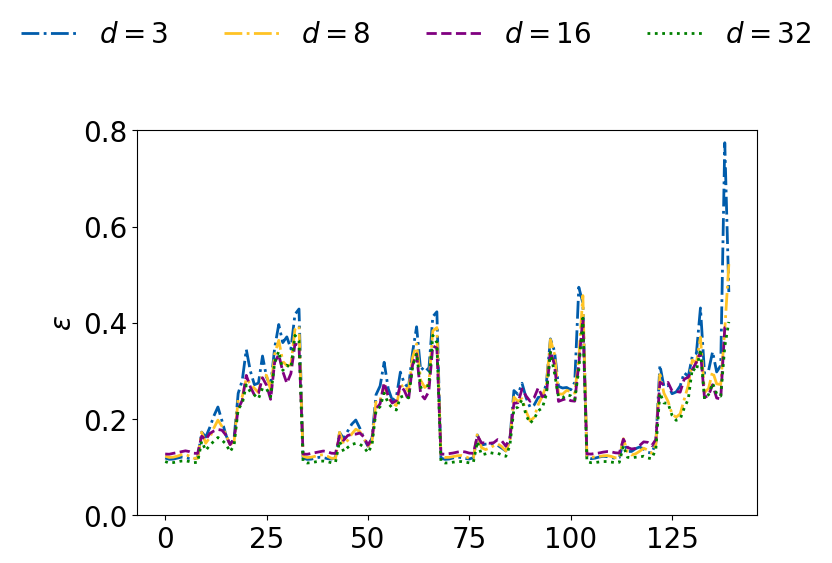

In [22]:
plt.rcParams.update({'font.size': 20})

line_colors = [(0, 92/255, 171/255), (255/255, 195/255, 37/255),  "purple","green","orange","blue"]#

line_styles = ['dashdot','dashdot','dashed','dotted','solid',"solid"]#


cmap_blue = plt.get_cmap('Blues')
cmap_red = plt.get_cmap('Reds')


fig, ax = plt.subplots(figsize=(8,5))
# Plotting the errors for PCA
ds= [3,8,16,32]
for i, d in enumerate(ds):

    save_name = f"save/new_model/part={part}_hidden_dim={hidden}_lr={lr}_batch_size={batch_size}_Wdecay={weight_decay}_latentd={d}.pth"
    ae =Autoencoder(latent_dims=d,hidden_dim=hidden)
    ae.load_state_dict(torch.load(save_name))
    ae = ae.to(device) 
    test_loss,errors = test_epoch(ae,device,loader_total)
    
    
    color=line_colors[i]
    # color = cmap_blue((5-i) / 5)  
    errors=np.sqrt(errors)
    ax.plot(errors, label=f'$d={d}$',  color=color,linestyle=line_styles[i],linewidth=2)
    print(d,errors[82],errors[138])

ax.set_ylabel(r'$\epsilon$')


ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.35), ncol=4, fontsize=20, frameon=False)
ax.set_ylim(0,0.8)
plt.show()


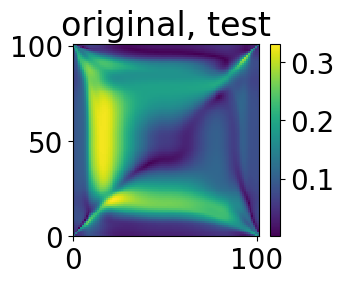

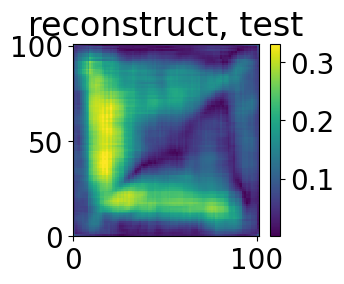

(array([[[[[ 1.33118123e-01, -1.08799282e-02, -2.53795460e-02, ...,
             4.40171100e-02, -1.59267597e-02, -1.09336846e-01],
           [-5.35302330e-03,  1.41394258e-01, -8.22630748e-02, ...,
            -8.92030150e-02, -8.48978609e-02, -4.99287024e-02],
           [-1.50831174e-02, -5.00808842e-02,  6.84272870e-02, ...,
            -1.05718985e-01, -1.05600968e-01,  1.64485816e-02],
           ...,
           [ 4.71134596e-02, -1.11925967e-01, -1.86858550e-01, ...,
             2.34826341e-01, -1.35148028e-02, -1.40370633e-02],
           [-1.74408928e-02, -1.18960559e-01, -1.64389417e-01, ...,
            -1.37845613e-02,  2.43317246e-01, -3.32834548e-03],
           [-1.19706213e-01, -7.26164579e-02, -3.33227939e-03, ...,
            -1.48094315e-02, -3.74056632e-03,  1.67642176e-01]],
 
          [[ 1.32274479e-01, -9.56353638e-03, -1.19039202e-02, ...,
             4.89396602e-02, -1.95838790e-02, -1.13569617e-01],
           [-5.36853867e-03,  1.36780664e-01, -4.50961068

In [23]:
plot_ae_outputs(dset_test, ae.encoder, ae.decoder,sample=0, text="test")